In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

In [2]:
row_start = 14

In [3]:
# metadata = dict()
filename = "1B - Xing - new.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)

In [4]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH1 Peak Detect,CH2,CH2 Peak Detect
0,-2.00000,9.88,10.04,1.224,1.240
1,-1.99997,9.88,9.80,1.216,1.184
2,-1.99994,9.88,9.96,1.208,1.240
3,-1.99990,9.88,9.80,1.216,1.192
4,-1.99987,9.88,10.04,1.216,1.240
...,...,...,...,...,...
124995,1.99984,0.04,-0.04,0.104,0.080
124996,1.99987,0.12,0.20,0.104,0.128
124997,1.99990,0.04,-0.04,0.104,0.072
124998,1.99994,0.12,0.20,0.104,0.136


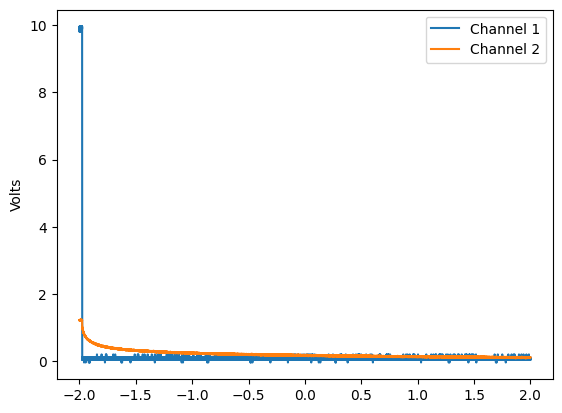

In [5]:
t_raw = data["TIME"]
ch1_raw = data["CH1"]
ch2_raw = data["CH2"]
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 2"
)
plt.ylabel("Volts")
plt.legend()


Text(0.5, 0, 'Time (s)')

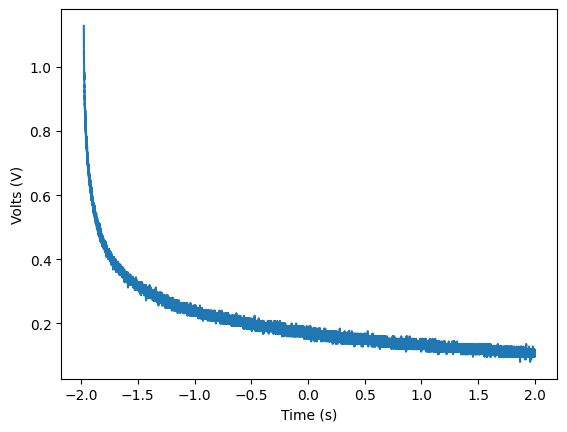

In [6]:
t = t_raw[ch1_raw < 1]
ch2_noisy = ch2_raw[ch1_raw < 1]
plt.plot(t, ch2_noisy)
plt.ylabel("Volts (V)")
plt.xlabel("Time (s)")

In [7]:
from scipy import signal

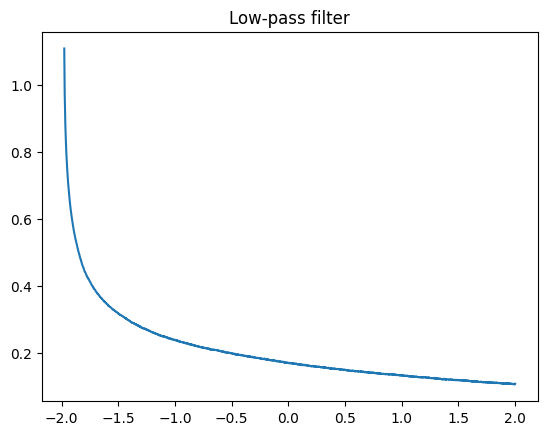

In [8]:
sample_frequency = 2e8
cutoff_frequency = 1e6
b, a = signal.butter(1, 2*cutoff_frequency/sample_frequency)
ch2 = signal.filtfilt(b, a, ch2_noisy)
plt.plot(t, ch2)
plt.title("Low-pass filter")
plt.show()

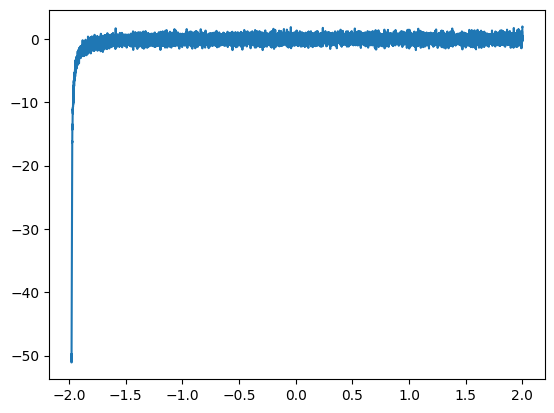

In [9]:
dt = np.array(t)[1] - np.array(t)[0]
dch2dt = np.gradient(ch2, dt)
plt.plot(t, dch2dt)

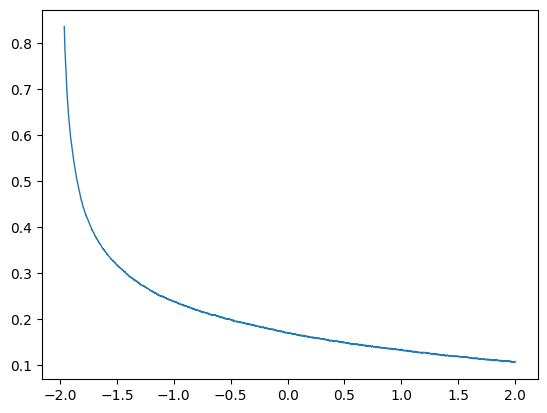

In [10]:
t_truncated = t[dch2dt>-10]
ch2_truncated = ch2[dch2dt>-10]
plt.plot(t_truncated, ch2_truncated,lw=1)

In [11]:
model = lambda t, A, RC, z: A * np.exp(-t/RC) + z
[A_model, RC_model, z_model], cov = sp.optimize.curve_fit(model, t, ch2)
cov

array([[ 4.90473778e-09,  6.25454745e-08, -5.84435441e-09],
       [ 6.25454745e-08,  8.12470939e-07, -6.93395550e-08],
       [-5.84435441e-09, -6.93395550e-08,  1.66978166e-08]])

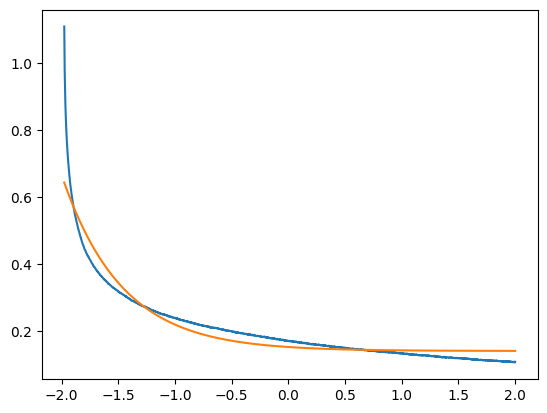

In [12]:
plt.plot(t, ch2)
plt.plot(t, model(t, A_model, RC_model, z_model))

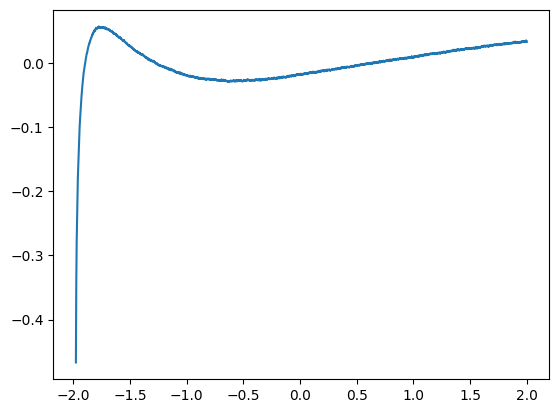

In [13]:
residual = model(t, A_model, RC_model, z_model) - ch2
plt.plot(t, residual)

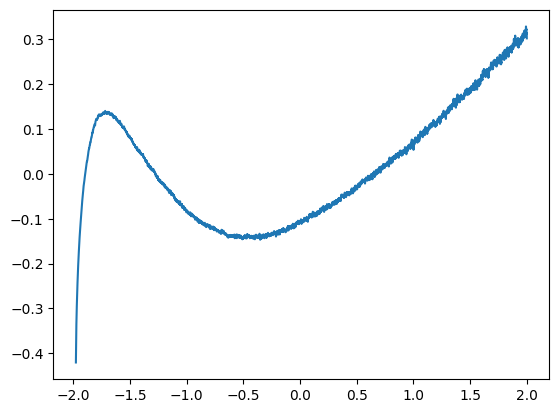

In [14]:
plt.plot(t, residual / ch2)

In [16]:
model_truncated = lambda t_truncated, A, RC, z: A * np.exp(-t_truncated/RC) + z
[A_model_truncated, RC_model_truncated, z_model_truncated], cov_truncated = sp.optimize.curve_fit(model_truncated, t_truncated, ch2_truncated)
cov_truncated

array([[ 6.45489070e-09,  7.21151517e-08, -6.37890274e-09],
       [ 7.21151517e-08,  8.25213387e-07, -6.63658965e-08],
       [-6.37890274e-09, -6.63658965e-08,  1.24552115e-08]])

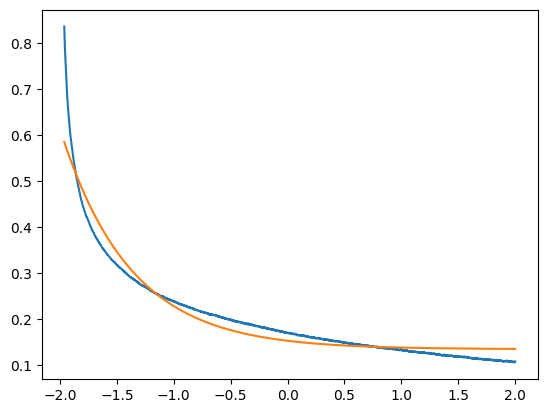

In [17]:
plt.plot(t_truncated, ch2_truncated)
plt.plot(t_truncated, model(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated))

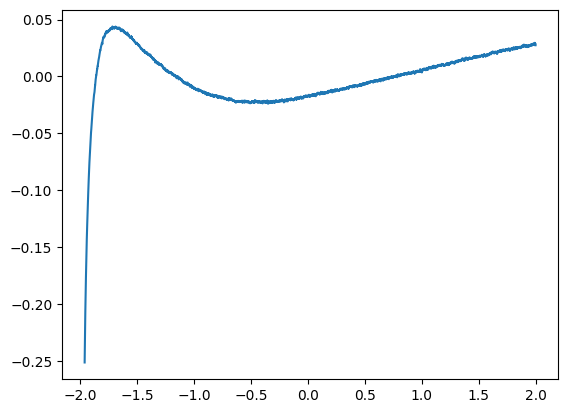

In [18]:
residual_truncated = model_truncated(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated) - ch2_truncated
plt.plot(t_truncated, residual_truncated)

In [19]:
t_trunc = np.array(t_truncated[residual_truncated == np.max(residual_truncated)])[0]

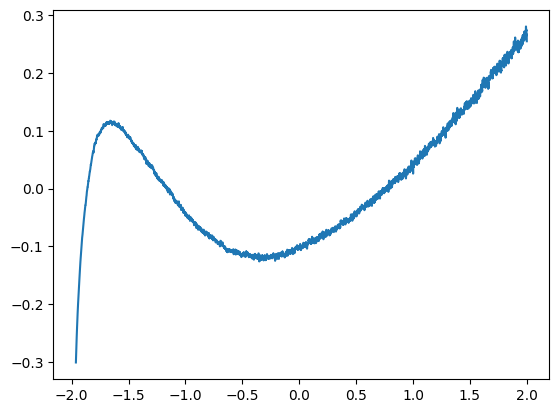

In [20]:
plt.plot(t_truncated, residual_truncated / ch2_truncated)

In [21]:
t_truncated2 = t[t>t_trunc]
ch2_truncated2 = ch2[t>t_trunc]
model_truncated2 = lambda t_truncated2, A, RC, z: A * np.exp(-t_truncated2/RC) + z
[A_model_truncated2, RC_model_truncated2, z_model_truncated2], cov_truncated2 = sp.optimize.curve_fit(model_truncated2, t_truncated2, ch2_truncated2)
cov_truncated2

array([[ 5.38189046e-09,  6.81903276e-08, -4.31151235e-09],
       [ 6.81903276e-08,  9.07902095e-07, -5.29118593e-08],
       [-4.31151235e-09, -5.29118593e-08,  3.82984443e-09]])

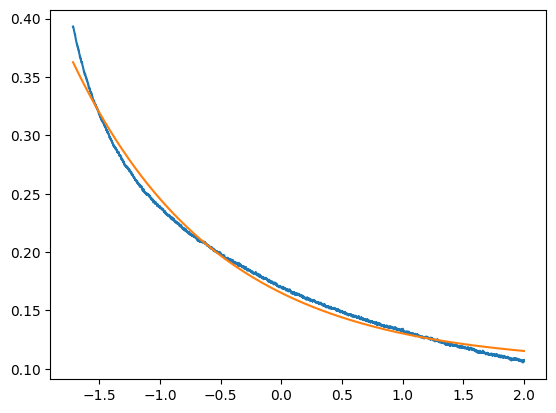

In [22]:
plt.plot(t_truncated2, ch2_truncated2)
plt.plot(t_truncated2, model(t_truncated2, A_model_truncated2, RC_model_truncated2, z_model_truncated2))

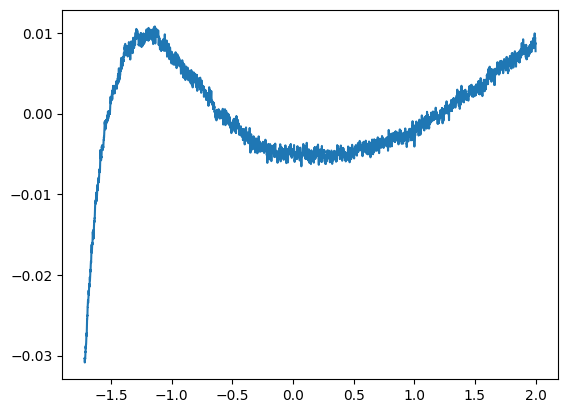

In [23]:
residual_truncated2 = model_truncated2(t_truncated2, A_model_truncated2, RC_model_truncated2, z_model_truncated2) - ch2_truncated2
plt.plot(t_truncated2, residual_truncated2)

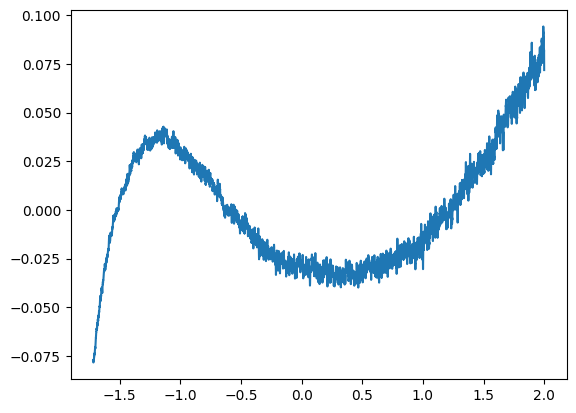

In [24]:
plt.plot(t_truncated2, residual_truncated2 / ch2_truncated2)

In [25]:
v_0 = 10
A_error = np.sqrt(cov[0,0]/t.size)
A_error_truncated = np.sqrt(cov_truncated[0,0]/t_truncated.size)
A_error_truncated2 = np.sqrt(cov_truncated2[0,0]/t_truncated2.size)
B_error = np.sqrt(cov[1,1]/t.size)
B_error_truncated = np.sqrt(cov_truncated[1,1]/t_truncated.size)
B_error_truncated2 = np.sqrt(cov_truncated2[1,1]/t_truncated2.size)
print("A:", A_model / v_0, "+-", A_error / v_0)
print("A-Truncated:", A_model_truncated / v_0, "+-", A_error_truncated / v_0)
print("A-Truncated2:", A_model_truncated2 / v_0, "+-", A_error_truncated2 / v_0)
print("B:", RC_model, "+-", B_error)
print("B-Truncated:", RC_model_truncated, "+-", B_error_truncated)

A: 0.0011826771949447167 +- 1.9867454274252262e-08
A-Truncated: 0.0018354519644921598 +- 2.2832728641704047e-08
A-Truncated2: 0.006109700481412026 +- 2.1521372747769418e-08
B: 0.5269072490078223 +- 2.557044248479348e-06
B-Truncated: 0.6130849805514235 +- 2.581644874631156e-06
